In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

warnings.filterwarnings("ignore")

In [2]:
np.random.seed(123456)

# List of countries by traffic-related death rate(2019)

## Read Data

In [3]:
road_dead_data = pd.read_csv("road_dead_sum.csv")

In [4]:
road_dead_data

,Unnamed: 0,Unnamed: 1,Estimated number of road traffic deaths,Estimated number of road traffic deaths.1,Estimated number of road traffic deaths.2,Estimated road traffic death rate (per 100 000 population),Estimated road traffic death rate (per 100 000 population).1,Estimated road traffic death rate (per 100 000 population).2
0,Country,Year,Both sexes,Male,Female,Both sexes,Male,Female
1,Afghanistan,2019,6033 [5227-6846],4853 [4204-5507],1180 [1023-1339],15.9 [13.7-18.0],24.8 [21.5-28.2],6.4 [5.5-7.2]
2,Afghanistan,2018,5295 [4578-6017],4339 [3751-4930],957 [827-1087],14.2 [12.3-16.2],22.7 [19.6-25.8],5.3 [4.6-6.0]
3,Afghanistan,2017,5490 [4737-6246],4433 [3825-5043],1057 [912-1203],15.1 [13.1-17.2],23.8 [20.5-27.0],6.0 [5.2-6.8]
4,Afghanistan,2016,5240 [4512-5970],4239 [3650-4829],1001 [862-1141],14.8 [12.8-16.9],23.3 [20.1-26.6],5.8 [5.0-6.6]
...,...,...,...,...,...,...,...,...
3656,Zimbabwe,2004,4188 [3423-4953],3529 [2884-4173],660 [539-780],34.8 [28.5-41.2],61.1 [49.9-72.2],10.6 [8.6-12.5]
3657,Zimbabwe,2003,4044 [3316-4772],3457 [2835-4080],587 [481-692],33.7 [27.7-39.8],59.8 [49.0-70.5],9.5 [7.8-11.2]
3658,Zimbabwe,2002,3869 [3190-4548],3337 [2751-3922],532 [439-625],32.4 [26.7-38.0],57.5 [47.4-67.6],8.6 [7.1-10.2]
3659,Zimbabwe,2001,3541 [2942-4141],3090 [2567-3613],451 [375-528],29.7 [24.7-34.7],53.2 [44.2-62.2],7.4 [6.1-8.6]


## Prep Data

In [5]:
road_dead_data.index.names = ["index"]
road_dead_data = road_dead_data[1:]
road_dead_data = road_dead_data.loc[
    :,
    [
        "Unnamed: 0",
        "Unnamed: 1",
        "Estimated road traffic death rate (per 100 000 population)",
    ],
]
road_dead_data = road_dead_data.rename(
    columns={"Unnamed: 0": "Country", "Unnamed: 1": "Year"}
)
road_dead_data.loc[:, "Estimated road traffic death rate (per 100 000 population)"] = (
    road_dead_data.loc[:, "Estimated road traffic death rate (per 100 000 population)"]
    .str.split(" ")
    .str[0]
).astype("float64")
road_dead_data["Year"] = road_dead_data["Year"].astype("int64")

In [6]:
road_dead_data

,Country,Year,Estimated road traffic death rate (per 100 000 population)
index,,,
1,Afghanistan,2019,15.9
2,Afghanistan,2018,14.2
3,Afghanistan,2017,15.1
4,Afghanistan,2016,14.8
5,Afghanistan,2015,14.4
...,...,...,...
3656,Zimbabwe,2004,34.8
3657,Zimbabwe,2003,33.7
3658,Zimbabwe,2002,32.4


## Get Only Year in Rule of Law Index

In [7]:
years = [2015, 2016, 2018, 2019, 2020, 2021]

In [8]:
road_dead_data = road_dead_data[road_dead_data["Year"].isin(years)].reset_index(
    drop=True
)

In [9]:
road_dead_data.loc[:, "Country"] = (
    road_dead_data.loc[:, "Country"]
    .str.replace(r"\(.*?\)", "")
    .str.split(",")
    .str[0]
    .str.replace(" ", "")
    .str.lower()
)

In [10]:
road_dead_data[road_dead_data.loc[:, "Country"] == "bahamas"]

,Country,Year,Estimated road traffic death rate (per 100 000 population)
40,bahamas,2019,7.7
41,bahamas,2018,8.2
42,bahamas,2016,8.2
43,bahamas,2015,8.3


# Rule of Law Index

## Read Data

In [11]:
sheets_name = ["WJP ROL Index " + str(year) + " Scores" for year in years]

In [12]:
sheets_name

['WJP ROL Index 2015 Scores',
 'WJP ROL Index 2016 Scores',
 'WJP ROL Index 2018 Scores',
 'WJP ROL Index 2019 Scores',
 'WJP ROL Index 2020 Scores',
 'WJP ROL Index 2021 Scores']

In [13]:
rule_of_law_data = pd.read_excel("rule_of_law_index_2021.xlsx", sheet_name=sheets_name)

In [14]:
for key in rule_of_law_data.keys():
    print(key)

WJP ROL Index 2015 Scores
WJP ROL Index 2016 Scores
WJP ROL Index 2018 Scores
WJP ROL Index 2019 Scores
WJP ROL Index 2020 Scores
WJP ROL Index 2021 Scores


## Prep Data

In [15]:
rule_of_law_data_table = pd.DataFrame()
for i, key in enumerate(rule_of_law_data.keys()):
    rule_of_law_data_by_year = rule_of_law_data[key].T
    rule_of_law_data_by_year.columns = rule_of_law_data_by_year.iloc[0, :]
    rule_of_law_data_by_year = rule_of_law_data_by_year[1:-1]
    rule_of_law_data_by_year = rule_of_law_data_by_year.dropna(axis=1)
    rule_of_law_data_by_year = rule_of_law_data_by_year.iloc[:, 2:]
    rule_of_law_data_by_year.insert(
        loc=0,
        column="Country",
        value=(
            rule_of_law_data_by_year.index.str.replace(r"\(.*?\)", "")
            .str.split(",")
            .str[0]
            .str.replace(" ", "")
            .str.lower()
        ),
    )
    rule_of_law_data_by_year = rule_of_law_data_by_year.reset_index(drop=True)
    rule_of_law_data_by_year.insert(loc=1, column="Year", value=years[i])
    print("year : " + str(years[i]))
    print("rule_of_law_data_by_year : " + str(rule_of_law_data_by_year.shape))
    rule_of_law_data_table = rule_of_law_data_table.append(
        rule_of_law_data_by_year, ignore_index=True
    )
    print("rule_of_law_data_table : " + str(rule_of_law_data_table.shape))

year : 2015
rule_of_law_data_by_year : (101, 55)
rule_of_law_data_table : (101, 55)
year : 2016
rule_of_law_data_by_year : (112, 55)
rule_of_law_data_table : (213, 55)
year : 2018
rule_of_law_data_by_year : (112, 55)
rule_of_law_data_table : (325, 55)
year : 2019
rule_of_law_data_by_year : (125, 55)
rule_of_law_data_table : (450, 55)
year : 2020
rule_of_law_data_by_year : (127, 55)
rule_of_law_data_table : (577, 55)
year : 2021
rule_of_law_data_by_year : (138, 55)
rule_of_law_data_table : (715, 55)


In [16]:
rule_of_law_data_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 55 columns):
 #   Column                                                                                             Non-Null Count  Dtype 
---  ------                                                                                             --------------  ----- 
 0   Country                                                                                            715 non-null    object
 1   Year                                                                                               715 non-null    int64 
 2   WJP Rule of Law Index: Overall Score                                                               715 non-null    object
 3   Factor 1: Constraints on Government Powers                                                         715 non-null    object
 4   1.1 Government powers are effectively limited by the legislature                                   715 non-null    object
 5   1

In [17]:
rule_of_law_data_table.isna().any()

Country
Country                                                                                              False
Year                                                                                                 False
WJP Rule of Law Index: Overall Score                                                                 False
Factor 1: Constraints on Government Powers                                                           False
1.1 Government powers are effectively limited by the legislature                                     False
1.2 Government powers are effectively limited by the judiciary                                       False
1.3 Government powers are effectively limited by independent auditing and review                     False
1.4 Government officials are sanctioned for misconduct                                               False
1.5 Government powers are subject to non-governmental checks                                         False
1.6 Transition of power is su

In [18]:
rule_of_law_data_table

Country,Country,Year,WJP Rule of Law Index: Overall Score,Factor 1: Constraints on Government Powers,1.1 Government powers are effectively limited by the legislature,1.2 Government powers are effectively limited by the judiciary,1.3 Government powers are effectively limited by independent auditing and review,1.4 Government officials are sanctioned for misconduct,1.5 Government powers are subject to non-governmental checks,1.6 Transition of power is subject to the law,...,7.6. Civil justice is effectively enforced,"7.7 Alternative dispute resolution mechanisms are accessible, impartial, and effective",Factor 8: Criminal Justice,8.1 Criminal investigation system is effective,8.2 Criminal adjudication system is timely and effective,8.3 Correctional system is effective in reducing criminal behavior,8.4 Criminal system is impartial,8.5 Criminal system is free of corruption,8.6 Criminal system is free of improper government influence,8.7. Due process of the law and rights of the accused
0,afghanistan,2015,0.353065,0.439951,0.587372,0.340316,0.395529,0.304959,0.59114,0.420388,...,0.472034,0.43084,0.24454,0.348142,0.348858,0.205947,0.127665,0.215376,0.198413,0.26738
1,albania,2015,0.520227,0.548409,0.600537,0.552433,0.542596,0.463466,0.571157,0.560267,...,0.563488,0.65428,0.430296,0.461467,0.465743,0.327259,0.477923,0.387114,0.380417,0.512152
2,argentina,2015,0.519839,0.486022,0.411287,0.360242,0.578881,0.313275,0.633982,0.618466,...,0.645861,0.71974,0.392186,0.282229,0.299948,0.293676,0.515534,0.516307,0.29881,0.538799
3,australia,2015,0.803472,0.830084,0.861129,0.873743,0.678869,0.791229,0.841374,0.934156,...,0.811211,0.895627,0.766052,0.683809,0.761095,0.706705,0.573879,0.876153,0.959401,0.801321
4,austria,2015,0.823531,0.848556,0.850406,0.830133,0.779544,0.774564,0.885754,0.970935,...,0.925612,0.724321,0.815728,0.630261,0.865944,0.839572,0.703049,0.890004,0.915771,0.865494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,uruguay,2021,0.713862,0.761539,0.788589,0.731791,0.692615,0.672003,0.777605,0.906632,...,0.655017,0.724244,0.563733,0.40572,0.519888,0.289025,0.606867,0.772967,0.7171,0.634565
711,uzbekistan,2021,0.490919,0.379968,0.30713,0.356302,0.327075,0.435823,0.393196,0.460283,...,0.408542,0.629235,0.447854,0.491473,0.601632,0.584792,0.401429,0.448391,0.200972,0.406288
712,venezuela,2021,0.265062,0.172643,0.314475,0.122551,0.071549,0.103027,0.238965,0.185288,...,0.168643,0.460975,0.120682,0.112447,0.117472,0.050339,0.115357,0.269512,0.014493,0.165155
713,vietnam,2021,0.488843,0.453357,0.386083,0.355869,0.537667,0.600538,0.401563,0.438423,...,0.404057,0.564373,0.457751,0.466648,0.536748,0.445963,0.52974,0.517245,0.26565,0.44226


# Merge

## Rename Country

In [19]:
maping_country_index = {
    "thebahamas": "bahamas",
    "coted'ivoire": "côted'ivoire",
    "czechrepublic": "czechia",
    "dominica": "dominica",
    "hongkongsar": "hongkongsar",
    "moldova": "republicofmoldova",
    "st.kittsandnevis": "st.kittsandnevis",
    "st.lucia": "saintlucia",
    "st.vincentandthegrenadines": "saintvincentandthegrenadines",
    "tanzania": "unitedrepublicoftanzania",
    "unitedkingdom": "unitedkingdomofgreatbritainandnorthernireland",
    "unitedstates": "unitedstatesofamerica",
}

In [20]:
rule_of_law_country = rule_of_law_data_table["Country"].tolist()

In [21]:
for i, name in enumerate(rule_of_law_country):
    if name in maping_country_index.keys():
        rule_of_law_country[i] = maping_country_index.get(name)

In [22]:
rule_of_law_data_table["Country"] = rule_of_law_country

## Merge

In [23]:
data_merge = road_dead_data.merge(rule_of_law_data_table, on=["Country", "Year"])

In [24]:
data_merge

,Country,Year,Estimated road traffic death rate (per 100 000 population),WJP Rule of Law Index: Overall Score,Factor 1: Constraints on Government Powers,1.1 Government powers are effectively limited by the legislature,1.2 Government powers are effectively limited by the judiciary,1.3 Government powers are effectively limited by independent auditing and review,1.4 Government officials are sanctioned for misconduct,1.5 Government powers are subject to non-governmental checks,...,7.6. Civil justice is effectively enforced,"7.7 Alternative dispute resolution mechanisms are accessible, impartial, and effective",Factor 8: Criminal Justice,8.1 Criminal investigation system is effective,8.2 Criminal adjudication system is timely and effective,8.3 Correctional system is effective in reducing criminal behavior,8.4 Criminal system is impartial,8.5 Criminal system is free of corruption,8.6 Criminal system is free of improper government influence,8.7. Due process of the law and rights of the accused
0,afghanistan,2019,15.9,0.34764,0.434391,0.585556,0.348819,0.434508,0.321632,0.579048,...,0.586057,0.531938,0.280142,0.303921,0.375214,0.255876,0.199751,0.238815,0.295471,0.291946
1,afghanistan,2018,14.2,0.344517,0.429199,0.522211,0.345911,0.442587,0.353415,0.557212,...,0.575394,0.456878,0.277761,0.287796,0.356053,0.255454,0.197807,0.248385,0.316966,0.28187
2,afghanistan,2016,14.8,0.345472,0.427645,0.598711,0.334747,0.38211,0.31135,0.579559,...,0.556165,0.384672,0.275993,0.350058,0.369236,0.24989,0.182482,0.234964,0.249475,0.295845
3,afghanistan,2015,14.4,0.353065,0.439951,0.587372,0.340316,0.395529,0.304959,0.59114,...,0.472034,0.43084,0.24454,0.348142,0.348858,0.205947,0.127665,0.215376,0.198413,0.26738
4,albania,2019,11.7,0.506076,0.485588,0.515998,0.315357,0.592498,0.414798,0.553333,...,0.469273,0.649412,0.465753,0.44346,0.441708,0.424599,0.662914,0.347641,0.365865,0.57408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,vietnam,2015,25.4,0.497281,0.415814,0.310439,0.278114,0.620547,0.547678,0.379208,...,0.408598,0.575224,0.497009,0.418817,0.515081,0.507854,0.680276,0.555001,0.285631,0.516405
429,zambia,2019,20.5,0.466405,0.484876,0.477997,0.373027,0.575328,0.580354,0.434368,...,0.659717,0.465809,0.433693,0.525086,0.497541,0.231406,0.496286,0.415235,0.44898,0.421314
430,zambia,2018,20.5,0.472209,0.472942,0.491551,0.3744,0.542682,0.526827,0.430447,...,0.727484,0.470112,0.415491,0.533151,0.499068,0.239628,0.474817,0.386962,0.385768,0.389039
431,zambia,2016,21.2,0.475911,0.496078,0.516131,0.423271,0.466926,0.537987,0.444721,...,0.745764,0.518164,0.415897,0.445737,0.510163,0.181792,0.527399,0.394106,0.504995,0.347086


## scatter plot

In [25]:
thailand_mask = data_merge["Country"] == "thailand"
not_thailand_mask = data_merge["Country"] != "thailand"

In [26]:
thailand = data_merge[thailand_mask]

In [27]:
not_thailand = data_merge[not_thailand_mask]

In [28]:
dpi = 100
# dpi = 600

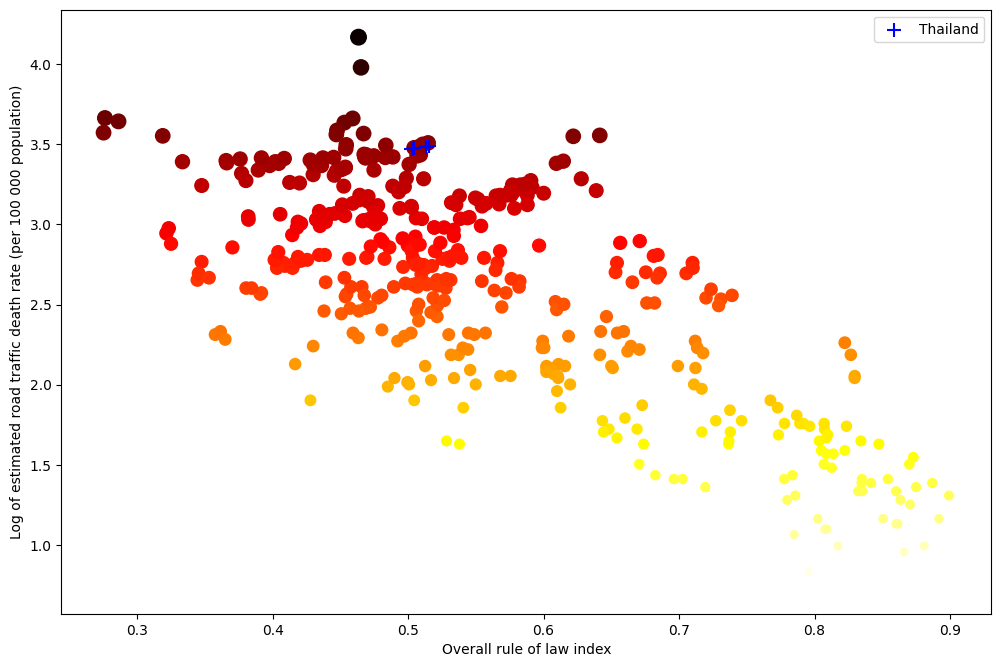

In [29]:
plt.figure(figsize=(12, 8), dpi=dpi)

log_y_not_thai = np.log(
    not_thailand["Estimated road traffic death rate (per 100 000 population)"]
)
ax = plt.scatter(
    not_thailand["WJP Rule of Law Index: Overall Score"],
    log_y_not_thai,
    s=log_y_not_thai * 30,
    c=log_y_not_thai,
    cmap=("hot_r"),
)

log_y_thai = np.log(
    thailand["Estimated road traffic death rate (per 100 000 population)"]
)
plt.scatter(
    thailand["WJP Rule of Law Index: Overall Score"],
    log_y_thai,
    s=log_y_thai * 30,
    c="b",
    marker="+",
    label="Thailand",
)

# plt.colorbar(ax)
plt.legend()
plt.xlabel("Overall rule of law index")
plt.ylabel("Log of estimated road traffic death rate (per 100 000 population)")
plt.show()

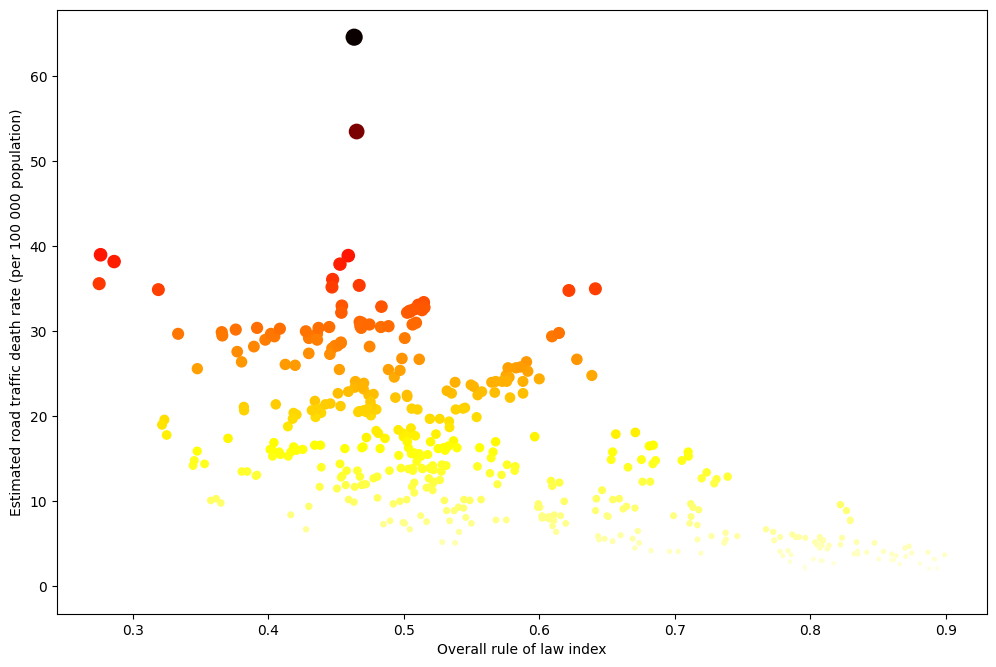

In [30]:
plt.figure(figsize=(12, 8), dpi=dpi)

log_y = np.log(data_merge["Estimated road traffic death rate (per 100 000 population)"])
log_y = data_merge["Estimated road traffic death rate (per 100 000 population)"]
ax = plt.scatter(
    data_merge["WJP Rule of Law Index: Overall Score"],
    log_y,
    s=log_y*2,
    c=log_y,
    cmap=("hot_r"),
)

# plt.colorbar(ax)
plt.xlabel("Overall rule of law index")
plt.ylabel("Estimated road traffic death rate (per 100 000 population)")
plt.show()

In [31]:
data_complete = data_merge.drop(columns=["Country", "Year"]).astype("float64")

In [32]:
data_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 433 entries, 0 to 432
Data columns (total 54 columns):
 #   Column                                                                                             Non-Null Count  Dtype  
---  ------                                                                                             --------------  -----  
 0   Estimated road traffic death rate (per 100 000 population)                                         433 non-null    float64
 1   WJP Rule of Law Index: Overall Score                                                               433 non-null    float64
 2   Factor 1: Constraints on Government Powers                                                         433 non-null    float64
 3   1.1 Government powers are effectively limited by the legislature                                   433 non-null    float64
 4   1.2 Government powers are effectively limited by the judiciary                                     433 non-null    float64

In [33]:
data_complete.describe().T

,count,mean,std,min,25%,50%,75%,max
Estimated road traffic death rate (per 100 000 population),433.0,15.792148,9.400356,0.000000,8.200000,14.300000,21.800000,64.600000
WJP Rule of Law Index: Overall Score,433.0,0.564251,0.139500,0.275271,0.467551,0.523817,0.654174,0.899190
Factor 1: Constraints on Government Powers,433.0,0.570241,0.160441,0.176435,0.453874,0.548654,0.663331,0.945519
1.1 Government powers are effectively limited by the legislature,433.0,0.604799,0.164628,0.109239,0.514540,0.606212,0.727114,0.972995
1.2 Government powers are effectively limited by the judiciary,433.0,0.549506,0.184038,0.126246,0.404109,0.534297,0.685000,0.957300
1.3 Government powers are effectively limited by independent auditing and review,433.0,0.537195,0.163652,0.099552,0.421980,0.505602,0.640125,0.950594
1.4 Government officials are sanctioned for misconduct,433.0,0.496873,0.178248,0.082765,0.367490,0.457806,0.583412,0.939704
1.5 Government powers are subject to non-governmental checks,433.0,0.592997,0.183572,0.091211,0.479134,0.601153,0.718203,0.973083
1.6 Transition of power is subject to the law,433.0,0.640076,0.195932,0.180636,0.491529,0.631161,0.791919,0.984763
Factor 2: Absence of Corruption,433.0,0.524530,0.188672,0.182328,0.380948,0.469707,0.664517,0.959884


# Split and Scaling

In [34]:
target_name = "Estimated road traffic death rate (per 100 000 population)"
feature_name = data_complete.columns[1:]

In [35]:
is_use_main_factor_feature = True
is_use_overall_factor_feature = False
is_use_only_overall_factor_feature = False
is_log_y = True
is_log_X = False

In [36]:
if is_use_main_factor_feature:
    feature_name = [
        "WJP Rule of Law Index: Overall Score",
        "Factor 1: Constraints on Government Powers",
        "Factor 2: Absence of Corruption",
        "Factor 3: Open Government ",
        "Factor 4: Fundamental Rights",
        "Factor 5: Order and Security",
        "Factor 6: Regulatory Enforcement",
        "Factor 7: Civil Justice",
        "Factor 8: Criminal Justice",
    ]
else:
    feature_name = list(
        set(feature_name)
        - {
            "Factor 1: Constraints on Government Powers",
            "Factor 2: Absence of Corruption",
            "Factor 3: Open Government ",
            "Factor 4: Fundamental Rights",
            "Factor 5: Order and Security",
            "Factor 6: Regulatory Enforcement",
            "Factor 7: Civil Justice",
            "Factor 8: Criminal Justice",
            "4.3 Due process of the law and rights of the accused",  # same value of 8.7
        }
    )
if not is_use_overall_factor_feature:
    feature_name = list(set(feature_name) - {"WJP Rule of Law Index: Overall Score"})
if is_use_only_overall_factor_feature:
    feature_name = ["WJP Rule of Law Index: Overall Score"]

In [37]:
feature_name.sort()

In [38]:
feature_name

['Factor 1: Constraints on Government Powers',
 'Factor 2: Absence of Corruption',
 'Factor 3: Open Government ',
 'Factor 4: Fundamental Rights',
 'Factor 5: Order and Security',
 'Factor 6: Regulatory Enforcement',
 'Factor 7: Civil Justice',
 'Factor 8: Criminal Justice']

In [39]:
# log ลบ target ที่เป็น 0
if is_log_y:
    data_complete = data_complete[data_complete[target_name] != 0]

## Split

In [40]:
X = data_complete[feature_name]
y = data_complete[target_name]

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Heatmap

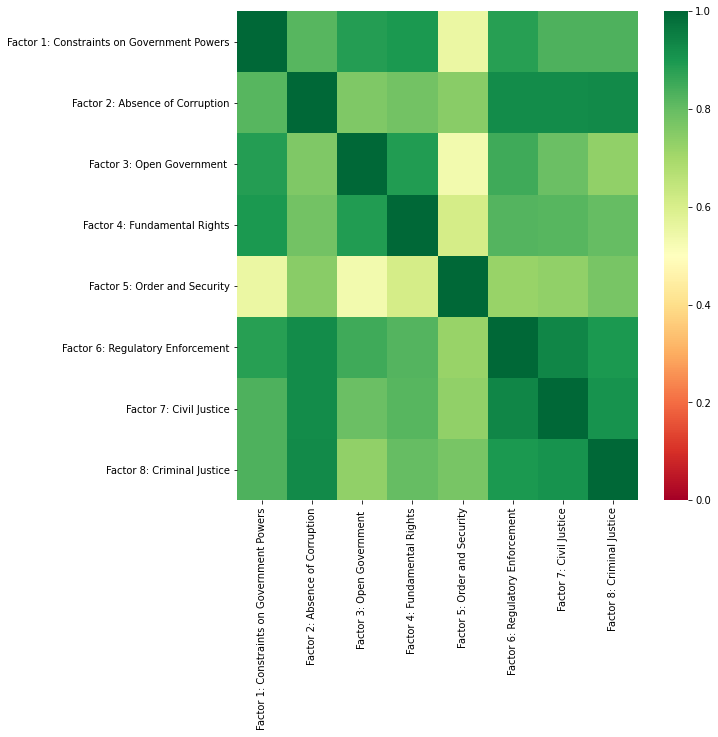

In [42]:
plt.figure(figsize=(9, 9))
corr_abs = np.abs(X_train[feature_name].corr())
g = sns.heatmap(corr_abs, cmap="RdYlGn", vmin=0, vmax=1)

## Scaling

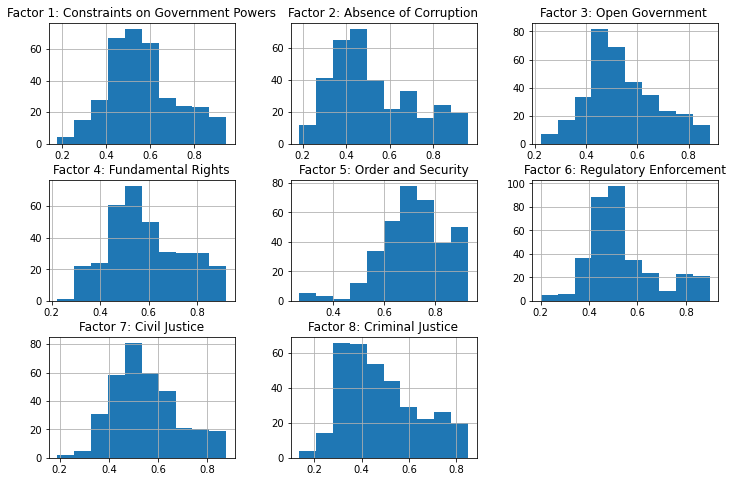

In [43]:
X_train.hist(figsize=(12, 8))
plt.show()

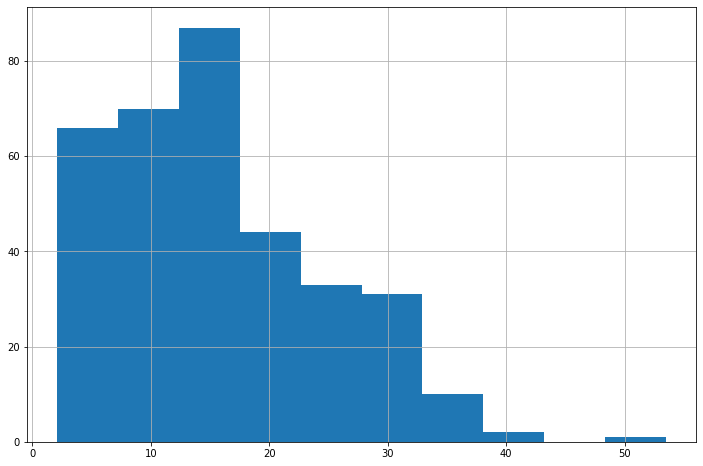

In [44]:
y_train.hist(figsize=(12, 8))
plt.show()

In [45]:
if is_log_y:
    y_train = np.log(y_train)
    y_test = np.log(y_test)
if is_log_X:
    X_train = np.log(X_train)
    X_test = np.log(X_test)

In [46]:
if is_log_X:
    X_train.hist(figsize=(12, 8))
    plt.show()

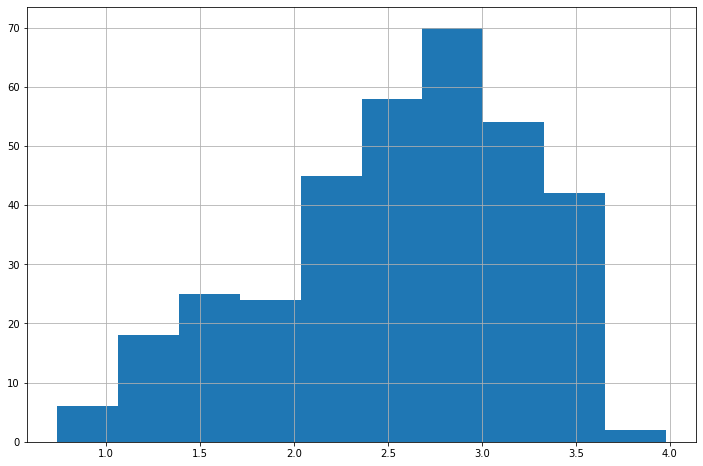

In [47]:
if is_log_y:
    y_train.hist(figsize=(12, 8))
    plt.show()

# Model

In [48]:
alphas = np.logspace(-10, 3, num=100)

In [49]:
reg = RidgeCV(alphas=alphas)
reg.fit(X_train, y_train)
y_pred_train = reg.predict(X_train)

In [50]:
reg.coef_

array([ 2.02693525, -0.24445311, -2.20013778, -0.68824936, -0.25992813,
       -1.44002371,  0.8037607 , -1.7507744 ])

# Prediction

## Training Set

In [51]:
y_pred_train = reg.predict(X_train)

In [52]:
y_train = y_train.to_numpy()
y_train = y_train.reshape(-1)
y_pred_train = y_pred_train.reshape(-1)

## Test Set

In [53]:
y_pred_test = reg.predict(X_test)

In [54]:
y_test = y_test.to_numpy()
y_test = y_test.reshape(-1)
y_pred_test = y_pred_test.reshape(-1)

# Evaluation

## Training Set

In [55]:
print("Train r2_score =\t\t\t", r2_score(y_train, y_pred_train))
print("Train mean_squared_error =\t\t", mean_squared_error(y_train, y_pred_train))
print("Train mean_absolute_error =\t\t", mean_absolute_error(y_train, y_pred_train))
print(
    "Train mean_absolute_percentage_error =",
    mean_absolute_percentage_error(y_train, y_pred_train),
)

Train r2_score =			 0.630119688652155
Train mean_squared_error =		 0.16297011543991483
Train mean_absolute_error =		 0.3276652238608662
Train mean_absolute_percentage_error = 0.1416353941128521


### Scatter Plot between Actual and Predicted Values

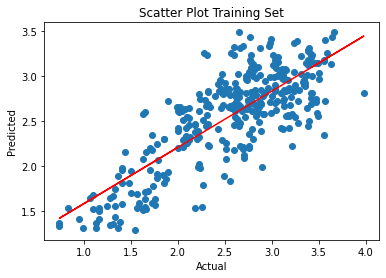

In [56]:
plt.scatter(y_train, y_pred_train)

m, b = np.polyfit(y_train, y_pred_train, 1)
plt.plot(y_train, m * y_train + b, color="red")

plt.title("Scatter Plot Training Set")
plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.show()

## Test Set

In [57]:
print("Test r2_score =\t\t\t", r2_score(y_test, y_pred_test))
print("Test mean_squared_error =\t\t", mean_squared_error(y_test, y_pred_test))
print("Test mean_absolute_error =\t\t", mean_absolute_error(y_test, y_pred_test))
print(
    "Test mean_absolute_percentage_error =",
    mean_absolute_percentage_error(y_test, y_pred_test),
)

Test r2_score =			 0.6310624974042942
Test mean_squared_error =		 0.186787776247439
Test mean_absolute_error =		 0.33276249505364247
Test mean_absolute_percentage_error = 0.14166981794972702


### Scatter Plot between Actual and Predicted Values

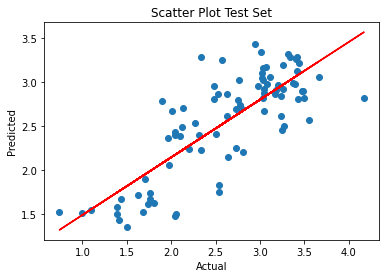

In [58]:
plt.scatter(y_test, y_pred_test)

m, b = np.polyfit(y_test, y_pred_test, 1)
plt.plot(y_test, m * y_test + b, color="red")

plt.title("Scatter Plot Test Set")
plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.show()

In [59]:
np.log(y)

0      2.766319
1      2.653242
2      2.694627
3      2.667228
4      2.459589
         ...   
428    3.234749
429    3.020425
430    3.020425
431    3.054001
432    3.039749
Name: Estimated road traffic death rate (per 100 000 population), Length: 430, dtype: float64

In [60]:
X2 = sm.add_constant(X)
est = sm.OLS(
    pd.Series(
        np.log(y),
        name="Log of estimated road traffic death rate (per 100 000 population)",
    ),
    X2,
)
est2 = est.fit()
print(est2.summary())

                                                    OLS Regression Results                                                   
Dep. Variable:     Log of estimated road traffic death rate (per 100 000 population)   R-squared:                       0.634
Model:                                                                           OLS   Adj. R-squared:                  0.627
Method:                                                                Least Squares   F-statistic:                     91.28
Date:                                                               Mon, 31 Jan 2022   Prob (F-statistic):           4.46e-87
Time:                                                                       18:50:20   Log-Likelihood:                -224.18
No. Observations:                                                                430   AIC:                             466.4
Df Residuals:                                                                    421   BIC:                           

# Model

In [61]:
reg = DecisionTreeRegressor()
reg.fit(X_train, y_train)
y_pred_train = reg.predict(X_train)

# Prediction

## Training Set

In [62]:
y_pred_train = reg.predict(X_train)

In [63]:
y_train = y_train.reshape(-1)
y_pred_train = y_pred_train.reshape(-1)

## Test Set

In [64]:
y_pred_test = reg.predict(X_test)

In [65]:
y_test = y_test.reshape(-1)
y_pred_test = y_pred_test.reshape(-1)

# Evaluation

## Training Set

In [66]:
print("Train r2_score =\t\t\t", r2_score(y_train, y_pred_train))
print("Train mean_squared_error =\t\t", mean_squared_error(y_train, y_pred_train))
print("Train mean_absolute_error =\t\t", mean_absolute_error(y_train, y_pred_train))
print(
    "Train mean_absolute_percentage_error =",
    mean_absolute_percentage_error(y_train, y_pred_train),
)

Train r2_score =			 1.0
Train mean_squared_error =		 0.0
Train mean_absolute_error =		 0.0
Train mean_absolute_percentage_error = 0.0


### Scatter Plot between Actual and Predicted Values

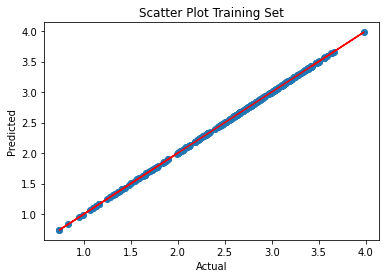

In [67]:
plt.scatter(y_train, y_pred_train)

m, b = np.polyfit(y_train, y_pred_train, 1)
plt.plot(y_train, m * y_train + b, color="red")

plt.title("Scatter Plot Training Set")
plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.show()

## Test Set

In [68]:
print("Test r2_score =\t\t\t", r2_score(y_test, y_pred_test))
print("Test mean_squared_error =\t\t", mean_squared_error(y_test, y_pred_test))
print("Test mean_absolute_error =\t\t", mean_absolute_error(y_test, y_pred_test))
print(
    "Test mean_absolute_percentage_error =",
    mean_absolute_percentage_error(y_test, y_pred_test),
)

Test r2_score =			 0.7472927331095551
Test mean_squared_error =		 0.12794207173825997
Test mean_absolute_error =		 0.24612902771148923
Test mean_absolute_percentage_error = 0.1045923837101994


### Scatter Plot between Actual and Predicted Values

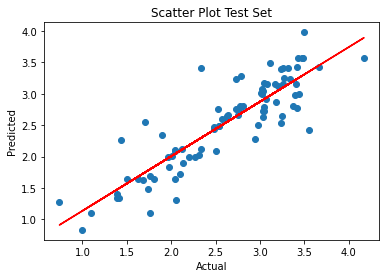

In [69]:
plt.scatter(y_test, y_pred_test)

m, b = np.polyfit(y_test, y_pred_test, 1)
plt.plot(y_test, m * y_test + b, color="red")

plt.title("Scatter Plot Test Set")
plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.show()

In [70]:
feature_importances = reg.feature_importances_

In [71]:
feature_name

['Factor 1: Constraints on Government Powers',
 'Factor 2: Absence of Corruption',
 'Factor 3: Open Government ',
 'Factor 4: Fundamental Rights',
 'Factor 5: Order and Security',
 'Factor 6: Regulatory Enforcement',
 'Factor 7: Civil Justice',
 'Factor 8: Criminal Justice']

In [72]:
(feature_importances - feature_importances.min()) / (
    feature_importances.max() - feature_importances.min()
)

array([0.0863278 , 0.04829172, 0.14935397, 0.11781338, 0.15618486,
       0.11178813, 0.        , 1.        ])

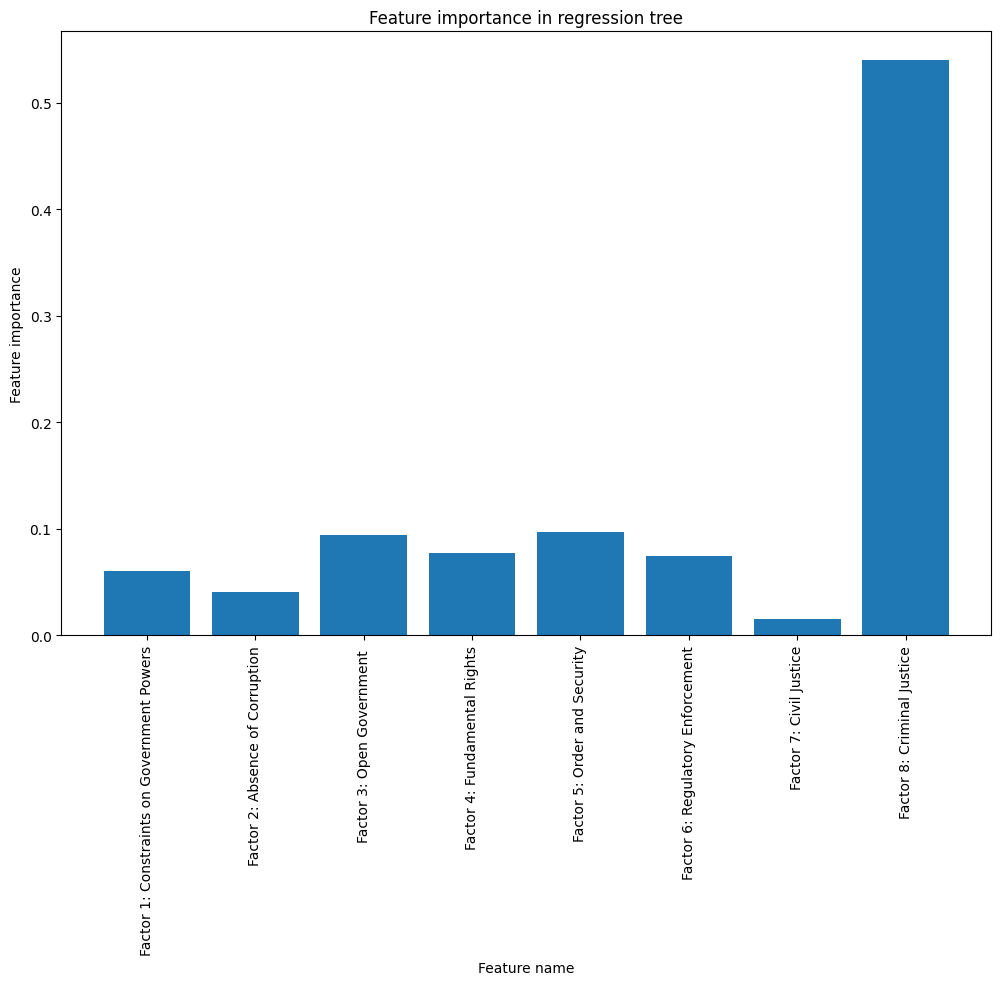

In [73]:
plt.figure(figsize=(12, 8), dpi=100)
x_pos = [i for i, _ in enumerate(feature_name)]

my_cmap = plt.get_cmap("RdYlGn")
rescale = lambda feature_importances: (
    feature_importances - feature_importances.min()
) / (feature_importances.max() - feature_importances.min())
plt.bar(
    x_pos,
    feature_importances,
    #     color=my_cmap(rescale(feature_importances)),
)
plt.xlabel("Feature name")
plt.ylabel("Feature importance")
plt.title("Feature importance in regression tree")
plt.xticks(x_pos, feature_name)
plt.xticks(rotation="vertical")
plt.show()